<a href="https://colab.research.google.com/github/migostro/laboratorio-de-visao/blob/main/DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files, drive
import os
import cv2
import imageio
from skimage import filters
from skimage.color import rgb2gray
import skimage
import csv

In [ ]:
def setFigSize():
    return((5,5))

def myImgShow(img):
    plt.figure(figsize=setFigSize())
    plt.axis('equal')
    plt.imshow(img,cmap='gray')
    plt.show()


###1 - Soma de gradiente

In [ ]:
# recebe as dimensões da imagem
# constroi e retorna o gradiente com o tamanho da imagem
def calcula_gradiente(dim):
    n = dim[0]
    m = dim[1]

    linha = np.array(np.arange(m))

    matriz = np.array([])

    for i in range(n):
        matriz = np.concatenate([matriz, linha])
    #matriz = np.concatenate([matriz, matriz, matriz])
    matriz = np.reshape(matriz, [dim[0], dim[1]])

    #gradiente = np.zeros(dim)
    gradiente = matriz.copy()
    #gradiente[:,:,1] = matriz.copy()
    #gradiente[:,:,2] = matriz.copy()

    max = m-1
    ##################################### SOMANDO #########################################
    # gradiente = (gradiente/max)*255/2
    # gradiente = gradiente.astype(np.uint16)

    ##################################### MULTIPLICANDO ###################################
    gradiente = (gradiente/(2*max))+0.5

    return gradiente

# Recebe uma imagem e um gradiente preciamente calculado
# Retorna a imagem com o gradiente
def aplica_gradiente(img, gradiente):
    ##################################### SOMANDO #########################################
    # nova_imagem = img/2 + gradiente
    # #max = np.max(nova_imagem)
    # #nova_imagem = (nova_imagem/max)*255
    
    ##################################### MULTIPLICANDO ###################################
    nova_imagem = np.multiply(img, gradiente)

    nova_imagem = nova_imagem.astype(np.uint8)
    return nova_imagem

###2 - Logaritmo da imagem

In [ ]:
def aplica_logaritmo(img):

    nova_imagem = img.astype(np.uint16)
    nova_imagem = nova_imagem + 1
    
    nova_imagem = np.log2(nova_imagem)

    nova_imagem = nova_imagem*32
    nova_imagem[nova_imagem > 255] = 255
    nova_imagem = nova_imagem.astype(np.uint8)

    return nova_imagem

###3 - Exponencial da imagem

In [ ]:
def aplica_exponencial(img):
    # pixels da imagem ficam entre [0 ,1]
    nova_imagem = img/255

    # pixels ficam entre [1, 2]
    nova_imagem = nova_imagem + 1

    # pixels ficam entre [e, e^2]
    nova_imagem = np.exp(nova_imagem)

    # pixels ficam entre [0, e^2-e]
    nova_imagem = nova_imagem - np.exp(1)

    # pixels ficam entre [0, 1]
    nova_imagem = nova_imagem/(np.exp(2)-np.exp(1))

    # pixels ficam entre [0, 255]
    nova_imagem = nova_imagem*255

    nova_imagem = nova_imagem.astype(np.uint8)
    return nova_imagem

###4 - Filtro da média implementado usando convolução

In [ ]:
def copia_imagem(imagem):
    num_linhas = imagem.shape[0]
    num_colunas = imagem.shape[1]

    copia = np.zeros([num_linhas+2, num_colunas+2])

    #copia o meio
    copia[1:num_linhas+1, 1:num_colunas+1] = imagem.copy()
    
    # copia as 4 bordas da imagem
    copia[1:num_linhas+1, 0] = imagem[0:num_linhas, 0].copy()
    copia[0, 1:num_colunas+1] = imagem[0, 0:num_colunas].copy()
    copia[1:num_linhas+1, num_colunas+1] = imagem[0:num_linhas, num_colunas-1].copy()
    copia[num_linhas+1, 1:num_colunas+1] = imagem[num_linhas-1, 0:num_colunas].copy()

    # copia as pontas da imagem
    copia[0, 0] = imagem[0, 0]
    copia[0, num_colunas+1] = imagem[0,num_colunas-1]
    copia[num_linhas+1, 0] = imagem[num_linhas-1,0]
    copia[num_linhas+1,num_colunas+1] = imagem[num_linhas-1,num_colunas-1]

    # transforma em inteiro
    copia = copia.astype(np.uint8)

    return copia


# Recebe uma imagem e uma mascara
# a mascara deve ser quadrada e com comprimento ímpar
# retorna uma imagem com a mascara aplicada
def filtra(imagem, mascara):

    copia = copia_imagem(imagem)

    imagem_filtrada = np.zeros(imagem.shape)

    n = np.arange(1, imagem.shape[0]+1)
    m = np.arange(1, imagem.shape[1]+1)

    for i in n:
        for j in m:
            imagem_filtrada[i-1,j-1] = np.sum(np.multiply(copia[i-1:i+2,j-1:j+2], mascara))
    #puta = np.mean(copia[0:3,0:3])
    #print(puta)
    
    return imagem_filtrada

# recebe o raio que o filtro afetara
def aplica_media(imagem):
    mascara = np.ones([3,3])/9
    #nova_imagem = np.ones(imagem.shape)
#
    #nova_imagem[:,:,0] = filtra(imagem[:,:,0], mascara)
    #nova_imagem[:,:,1] = filtra(imagem[:,:,1], mascara)
    #nova_imagem[:,:,2] = filtra(imagem[:,:,2], mascara)
    nova_imagem = cv2.filter2D(imagem, -1, mascara)
    nova_imagem = nova_imagem.astype(np.uint8)

    return nova_imagem

###Aplica e os métodos e salva as imagens formadas

In [ ]:
drive.mount('/content/drive')

# pasta onde as imagens vão ser lidas
pasta_raiz = "/content/drive/MyDrive/ime/mac0417/ep"

pasta_original = pasta_raiz + "/originalDataSet"

# Algoritmo recursivo que recebe a pasta_raiz que estão as imagens e uma lista vazia caminhos
# Retorna todos os caminhos até as imagens
def monta_caminhos(pasta, caminhos = []):
    for nome in os.listdir(pasta):
        caminho = os.path.join(pasta, nome)

        # Adiciona apenas caminhos que são de arquivos (que no nosso caso são imagens)
        if os.path.isfile(caminho):
            caminhos.append(caminho)
        else:
            monta_caminhos(caminho, caminhos)
    return caminhos

caminhos = monta_caminhos(pasta_original)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(len(caminhos))
print(caminhos)

441
['/content/drive/MyDrive/ime/mac0417/ep/originalDataSet/dia/interior/IMG_0431.JPG', '/content/drive/MyDrive/ime/mac0417/ep/originalDataSet/dia/interior/IMG_0432.JPG', '/content/drive/MyDrive/ime/mac0417/ep/originalDataSet/dia/interior/IMG_0433.JPG', '/content/drive/MyDrive/ime/mac0417/ep/originalDataSet/dia/interior/IMG_0435.JPG', '/content/drive/MyDrive/ime/mac0417/ep/originalDataSet/dia/interior/IMG_0436.JPG', '/content/drive/MyDrive/ime/mac0417/ep/originalDataSet/dia/interior/IMG_0437.JPG', '/content/drive/MyDrive/ime/mac0417/ep/originalDataSet/dia/interior/IMG_0438.JPG', '/content/drive/MyDrive/ime/mac0417/ep/originalDataSet/dia/interior/IMG_0439.JPG', '/content/drive/MyDrive/ime/mac0417/ep/originalDataSet/dia/interior/IMG_0440.JPG', '/content/drive/MyDrive/ime/mac0417/ep/originalDataSet/dia/interior/IMG_0441.JPG', '/content/drive/MyDrive/ime/mac0417/ep/originalDataSet/dia/interior/IMG_0442.JPG', '/content/drive/MyDrive/ime/mac0417/ep/originalDataSet/dia/interior/IMG_0443.JPG',

In [ ]:
############## testes ####################
img = imageio.imread(caminhos[0])
imagem_exp = aplica_exponencial(img)
grad = calcula_gradiente(img.shape)
imagem_grad = aplica_gradiente(img, grad)

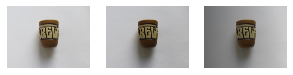

In [ ]:
############## testes ####################

vetor = [img, imagem_exp, imagem_grad]
fig=plt.figure(figsize=setFigSize())
for a in range(len(vetor)):
  #plt.add_subplot()
  fig.add_subplot(1, 3, a+1).set_axis_off()
  plt.imshow(vetor[a])

plt.show()

#myImgShow(img)
#myImgShow(imagem_exp)
#myImgShow(imagem_grad)

In [ ]:
imagem_log = aplica_logaritmo(img)
imagem_media = aplica_media(img)

In [ ]:
print(np.min(imagem_log))
print(np.max(imagem_log))

0
254


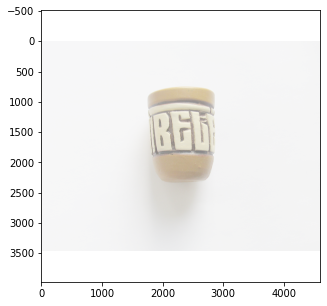

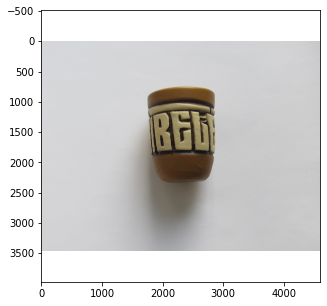

In [ ]:
myImgShow(imagem_log)
myImgShow(imagem_media)


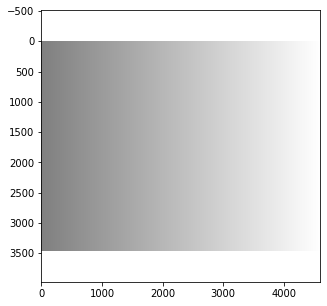

In [ ]:
myImgShow(grad)

In [ ]:
print(np.max(imagem_grad))
print(np.min(imagem_grad))

225
0


In [ ]:
def constroi_csv(caminhos):
  novo_arquivo = open('metadados.csv', 'w', newline='', encoding='utf-8')

  arquivo_csv = csv.writer(novo_arquivo)


  arquivo_csv.writerow(['DIR', 'LIGHT', 'INDOOR'])
  for caminho in caminhos:
    pasta = caminho.split('/')

    dir = os.path.join(pasta[-3], pasta[-2], pasta[-1])

    if pasta[-2] == 'Exterior':
      indoor = 'VERDADEIRO'
    else:
      indoor = 'FALSO'

    if pasta[-3] == 'dia':
      light = 'Dia'
    else:
      light = 'Noite'

    arquivo_csv.writerow([dir, light, indoor])



In [ ]:
# calcula previamente o gradiente
img = imageio.imread(caminhos[0])
gradiente = calcula_gradiente(img[:,:,0].shape)
gradiente.shape

(3456, 4608)

In [ ]:
# pasta onde os arquivos serão salvos
pasta_augmentation = pasta_raiz + "/augmentedDataSet"
pasta_gray = pasta_raiz + "/originalGreyDataSet"

# assume que todas as fotos tem o mesmo tamanho
for caminho in caminhos:
    imagem_original = imageio.imread(caminho)

    imagem_cinza = rgb2gray(imagem_original)

    nome_arquivo = caminho.split('/')[-1]

    # pastas que estão entre a originalDataSet e o arquivo (não incluindo nenhum dos dois)
    local_salvo = caminho[len(pasta_original):len(caminho)-len(nome_arquivo)]

    imagem_cinza = imagem_cinza*255
    imagem_cinza = imagem_cinza.astype(np.uint8)

    # Gera as novas imagens
    imagem_media =       aplica_media(imagem_cinza)
    imagem_log =         aplica_logaritmo(imagem_cinza)
    imagem_exponencial = aplica_exponencial(imagem_cinza)
    imagem_gradiente =   aplica_gradiente(imagem_cinza, gradiente)

    # nomes que cada foto será salva    
    arquivo_cinza       =                     nome_arquivo
    arquivo_media       = 'media_'          + nome_arquivo
    arquivo_log         = 'log_'            + nome_arquivo
    arquivo_exponencial = 'exponencial_'    + nome_arquivo
    arquivo_gradiente   = 'gradiente_'      + nome_arquivo

    # cria os diretorio recursivamente caso não existam
    # TODO: fazer isto fora deste for
    if not os.path.isdir(pasta_gray + local_salvo):
      os.makedirs(pasta_gray + local_salvo)

    if not os.path.isdir(pasta_augmentation + local_salvo):
      os.makedirs(pasta_augmentation + local_salvo)

    imageio.imsave(pasta_gray         + local_salvo + arquivo_cinza,        imagem_cinza)
    imageio.imsave(pasta_augmentation + local_salvo + arquivo_cinza,        imagem_cinza)
    imageio.imsave(pasta_augmentation + local_salvo + arquivo_media,        imagem_media)
    imageio.imsave(pasta_augmentation + local_salvo + arquivo_log,          imagem_log)  
    imageio.imsave(pasta_augmentation + local_salvo + arquivo_exponencial,  imagem_exponencial)  
    imageio.imsave(pasta_augmentation + local_salvo + arquivo_gradiente,    imagem_gradiente)

In [ ]:
constroi_csv(caminhos)

In [ ]:
# TODO: terminar função (fotos estão muito pequenas)
def printa_fotos(col, lin,  local_pasta):
  caminhos_imagen_salvas = monta_caminhos(local_pasta)
  fig=plt.figure()
  for i in range(len(caminhos_imagen_salvas[0:col*lin])):
    imagem = imageio.imread(caminhos_imagen_salvas[i])
    fig.add_subplot(col, lin, i+1).set_axis_off()
    plt.imshow(imagem)

  plt.show()

printa_fotos(2, 10, '/content/drive/MyDrive/ime/mac0417/ep/augmentedDataSet')